In [1]:
import numpy as np 
import os
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential 
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from keras import utils
from keras.utils import plot_model
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
import pandas as pd
import visualkeras
import matplotlib.pyplot as plt  # doctest: +SKIP
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
%matplotlib inline

In [2]:
for dirname, _, filenames in os.walk('C:/Users/Dell/AppData/Local/Programs/Python/Python37/Scripts/covid_data'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [3]:
labels = ['PNEUMONIA', 'COVID-19']
img_size = 64
def training_data_gen(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_array = cv2.resize(img_array, (img_size, img_size))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [4]:
train = training_data_gen('C:/Users/Dell/AppData/Local/Programs/Python/Python37/Scripts/covid_data/train')
test = training_data_gen('C:/Users/Dell/AppData/Local/Programs/Python/Python37/Scripts/covid_data/test')
val = training_data_gen('C:/Users/Dell/AppData/Local/Programs/Python/Python37/Scripts/covid_data/val') 

In [5]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)
    
for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [6]:
x_train = np.array(x_train)/255
x_val = np.array(x_val)/255
x_test = np.array(x_test)/255

In [7]:
x_train = np.around(x_train, decimals =3)
x_val = np.around(x_val, decimals = 3)
x_test = np.around(x_test, decimals =3)

In [8]:
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [9]:
data_gen = ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization = False, zca_whitening=False, rotation_range = 25, zoom_range = 0.3, width_shift_range = 0.15, height_shift_range = 0.15, horizontal_flip = True, vertical_flip = False)
data_gen.fit(x_train)

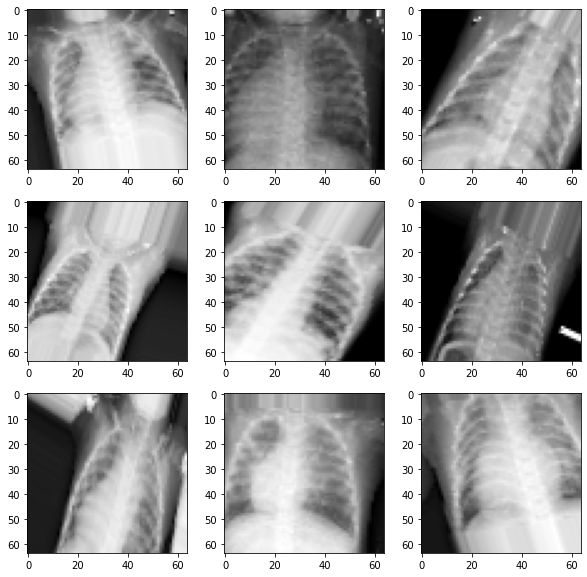

In [10]:
plt.figure(figsize = (10,10))

for X_batch, y_batch in data_gen.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(X_batch[i].reshape(64, 64), cmap=pyplot.get_cmap( 'gray' ))
# show the plot
    pyplot.show()
    break

In [11]:
model = Sequential()

model.add(Conv2D(32, (3, 3), strides = 1, padding = 'same', activation = 'relu', input_shape=(64, 64, 1)))
model.add(MaxPool2D((2, 2), strides = 2, padding = 'same'))

model.add(Conv2D(64, (3, 3), strides = 1, padding = 'same', activation = 'relu'))
model.add(Dropout(0.1))
model.add(MaxPool2D((2, 2), strides = 2, padding = 'same'))

model.add(Conv2D(64, (3, 3), strides = 1, padding = 'same', activation = 'relu'))
model.add(MaxPool2D((2, 2), strides = 2, padding = 'same'))

model.add(Conv2D(128, (3, 3), strides = 1, padding = 'same', activation = 'relu'))
model.add(Dropout(0.2))
model.add(MaxPool2D((2, 2), strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = "rmsprop", loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0

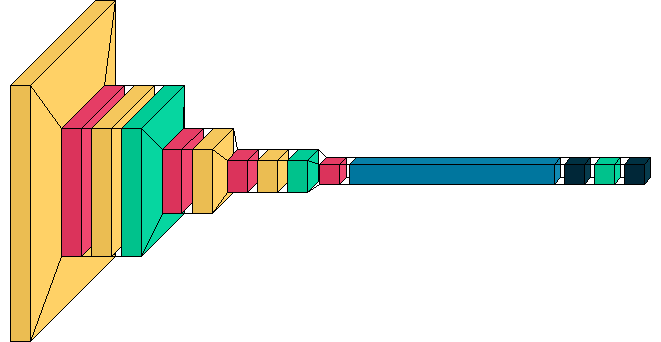

In [12]:
visualkeras.layered_view(model)


In [13]:
learning_rate = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose = 1, factor=0.3, min_lr = 0.00001)


In [17]:
history = model.fit(data_gen.flow(x_train, y_train, batch_size=32), epochs=50, validation_data=data_gen.flow(x_val, y_val), callbacks=[learning_rate])


Epoch 1/50
136/136 [==============================] - 29s 212ms/step - loss: 0.0512 - accuracy: 0.9825 - val_loss: 0.2004 - val_accuracy: 0.9355
Epoch 2/50
136/136 [==============================] - 28s 203ms/step - loss: 0.0528 - accuracy: 0.9807 - val_loss: 0.1666 - val_accuracy: 0.9355
Epoch 3/50
136/136 [==============================] - ETA: 0s - loss: 0.0461 - accuracy: 0.9837
Epoch 00003: ReduceLROnPlateau reducing learning rate to 1e-05.
136/136 [==============================] - 28s 205ms/step - loss: 0.0461 - accuracy: 0.9837 - val_loss: 0.2072 - val_accuracy: 0.9355
Epoch 4/50
136/136 [==============================] - 28s 209ms/step - loss: 0.0464 - accuracy: 0.9825 - val_loss: 0.1232 - val_accuracy: 0.9624
Epoch 5/50
136/136 [==============================] - 28s 207ms/step - loss: 0.0399 - accuracy: 0.9876 - val_loss: 0.1917 - val_accuracy: 0.9516
Epoch 6/50
136/136 [==============================] - 27s 200ms/step - loss: 0.0492 - accuracy: 0.9834 - val_loss: 0.1647 - va

In [18]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

21/21 [==============================] - 1s 45ms/step - loss: 0.1164 - accuracy: 0.9581
Loss of the model is -  0.11638636887073517
21/21 [==============================] - 1s 45ms/step - loss: 0.1164 - accuracy: 0.9581
Accuracy of the model is -  95.81465125083923 %


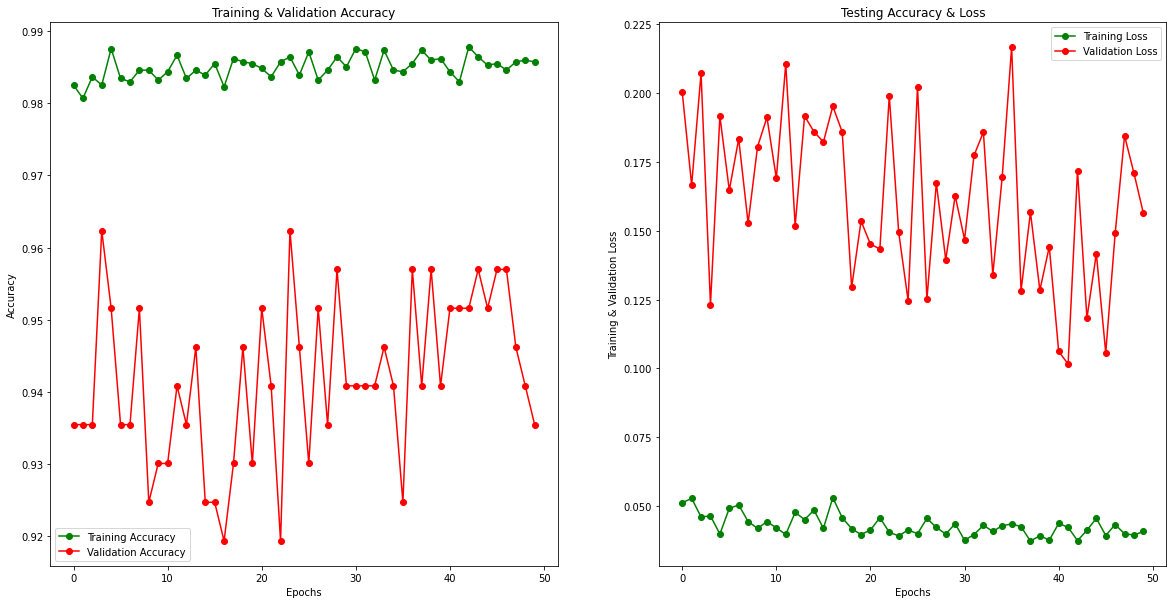

In [20]:
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

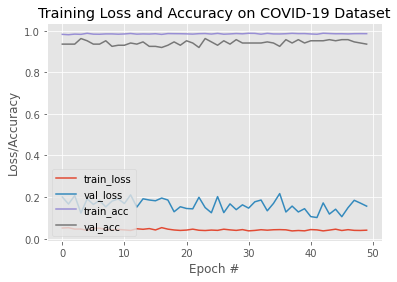

In [22]:
N = 50
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history .history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [23]:
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [24]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))


                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.93      1.00      0.97       390
   Normal (Class 1)       1.00      0.90      0.95       279

           accuracy                           0.96       669
          macro avg       0.97      0.95      0.96       669
       weighted avg       0.96      0.96      0.96       669



<AxesSubplot:>

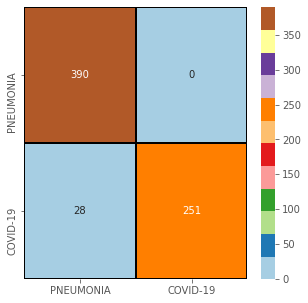

In [25]:
cm = confusion_matrix(y_test,predictions)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Paired", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [26]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

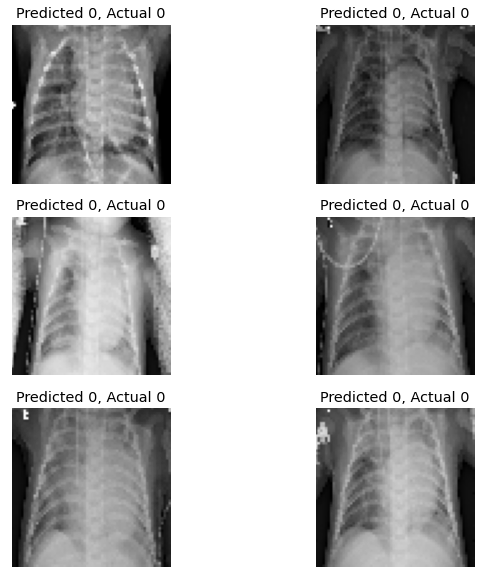

In [27]:
plt.figure(figsize = (10,10))

i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(64,64), cmap="gray")
    plt.title("Predicted {}, Actual {}".format(predictions[c], y_test[c]))
    i += 1

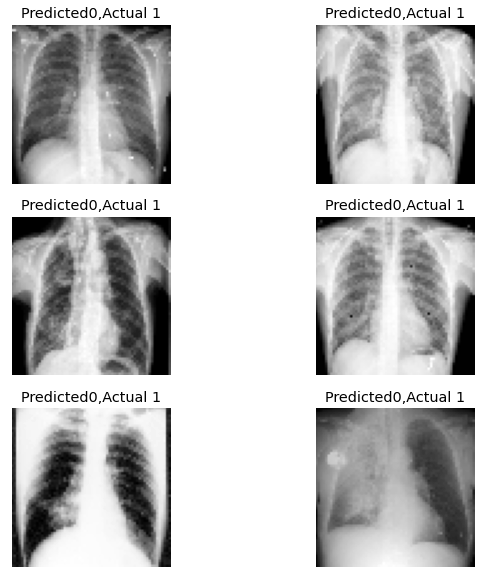

In [28]:
plt.figure(figsize = (10,10))

i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(64, 64), cmap="gray")
    plt.title("Predicted{},Actual {}".format(predictions[c], y_test[c]))
    i += 1

In [29]:
scores = model.evaluate(x_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

CNN Error: 4.19%
